<a href="https://colab.research.google.com/github/PedroHudson/PUC_MVP2/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Configuração para não exibir Warnings
import warnings
warnings.filterwarnings('ignore')

# Importação do Pandas
import pandas as pd

# Importação do Numpy
import numpy as np

# Importação do MissingNo para tratamento de missings
import missingno as ms


In [ ]:
# Importando dados da url para um dataframe

# url a importar

url_dados = 'https://github.com/PedroHudson/Deep_Learning/blob/main/emotion.csv?raw=true'

# carga do dataset através da url
dataset = pd.read_csv(url_dados, sep=';', encoding = 'ISO-8859-1')
dataset[['Text', 'Emotion']] = dataset['Text,Emotion'].str.split(',', 1, expand=True)
dataset = dataset[['Text', 'Emotion']]


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21444 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [ ]:
# Visualização da quantidade de instâncias e atributos do dataset
dataset.shape

(21459, 2)

In [ ]:
# Visualização da quantidade de linhas por coluna
dataset.count()

Text       21459
Emotion    21444
dtype: int64

In [ ]:
# Visualização dos tipos de dados
dataset.dtypes

Text       object
Emotion    object
dtype: object

In [ ]:
# Visualização das primeiras linhas do dataframe
dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
# Visualização das últimas linhas do dataframe
dataset.tail()

,Text,Emotion
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear
21458,I am dismayed,"but not surpris,fear"


**Data Preprocessing**

In [ ]:
dataset.isnull().sum()

Text        0
Emotion    15
dtype: int64

In [ ]:
# Ver o shape antes
dataset_antes = dataset.shape
print("Antes:\t", dataset_antes)

dataset.dropna(subset=['Emotion'], inplace=True)

# ver o shape depois
dataset_depois = dataset.shape
print("Depois:\t", dataset_depois)


Antes:	 (21459, 2)
Depois:	 (21444, 2)


In [ ]:
dataset.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [ ]:
# Visualização da quantidade de linhas por coluna
dataset.count()

Text       21444
Emotion    21444
dtype: int64

In [ ]:
dataset['Emotion'].value_counts()

happy                                                                                                                                              6864
sadness                                                                                                                                            5988
anger                                                                                                                                              2843
fear                                                                                                                                               2501
love                                                                                                                                               1641
                                                                                                                                                   ... 
 felt despondent and fearful , for his little grey mentor had given him no instructions 

In [ ]:
# One Hot Encoding
category = pd.get_dummies(dataset.Emotion)
dataset1 = pd.concat([dataset, category], axis=1)
dataset1 = dataset1.drop(columns='Emotion')

In [ ]:
X = dataset1['Text'].values
y = dataset1[['happy', 'sadness', 'anger', 'fear', 'love', 'surprise']].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
tokenizer = Tokenizer(num_words = 5000, oov_token='<x>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

Seq_train = tokenizer.texts_to_sequences(X_train)
Seq_test = tokenizer.texts_to_sequences(X_test)

Pad_train = pad_sequences(Seq_train)
Pad_test = pad_sequences(Seq_test)

**Model Construction**

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, LSTM
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

In [ ]:
model = Sequential([
    Embedding(input_dim = 5000, output_dim = 24),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    LSTM(128),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(6, activation='softmax')
])

In [ ]:
class callbackTarget(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.91 and logs.get('accuracy') >= 0.91):
      print('\nVal_accuracy and accuracy has reached >= 91%!')
      self.model.stop_training = True

callbacks = callbackTarget()

LR_reduction = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Model Train and Val**

In [ ]:
history = model.fit(
    Pad_train, y_train,
    epochs = 100,
    batch_size = 128,
    validation_data = (Pad_test, y_test),
    verbose = 1,
    callbacks = [callbacks, LR_reduction]
)

Epoch 1/100
135/135 [==============================] - 80s 524ms/step - loss: 1.8558 - accuracy: 0.2426 - val_loss: 1.5802 - val_accuracy: 0.3574 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 75s 559ms/step - loss: 1.5208 - accuracy: 0.3962 - val_loss: 1.5227 - val_accuracy: 0.4041 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 69s 514ms/step - loss: 1.2821 - accuracy: 0.5132 - val_loss: 1.9429 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 75s 556ms/step - loss: 1.0811 - accuracy: 0.5780 - val_loss: 0.9614 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 70s 521ms/step - loss: 0.8698 - accuracy: 0.6526 - val_loss: 0.8210 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 6/100
135/135 [==============================] - 70s 519ms/step - loss: 0.7347 - accuracy: 0.6906 - val_loss: 0.8599 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 7/100
135/135 [=========================

**Evaluate**

In [ ]:
import matplotlib.pyplot as plt

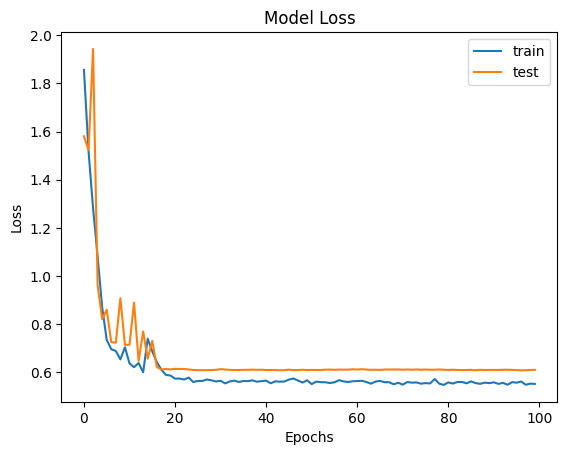

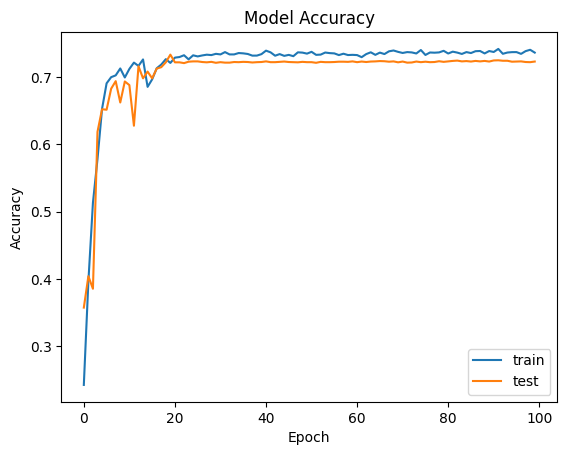

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()